In [1]:
from prevelop import preparation, exploration, clustering, evaluation

__Data Preparation and Preprocessing__

In [2]:
# Load the cad-data
cad_data = preparation.load_data(r"demo_data/CAPicard_cad_data_sample.xlsx")
# load process-data
process_data = preparation.load_data(r"demo_data/CAPicard_process_data_sample.xlsx")
# load link data
link_data = preparation.load_data(r"demo_data/CAPicard_link_data_sample.xlsx")

In [3]:
### clear data
# for cad-data received from SIMUS, apply the following cleaning steps
cad_data = preparation.clear_cad_data(cad_data)

In [4]:
### aggregate process data
process_data = preparation.aggregate_data(process_data, key='Teil', columns=['Aktivität','Basisressource','Produktionsmenge','Soll te','Soll tr'], methods=['encode','encode','mean','mean','mean'])

In [5]:
### prepare the data
# select numerical, binary and categorical columns for preprocessing
num_columns = ['L [mm]', 'B [mm]', 'H [mm]', 'Volumen [mm3]', 'Masse [kg]', 'Flächeninhalt [mm2]', 'Da max. [mm]', 'Di min. [mm]','Produktionsmenge','Soll te','Soll tr']
cat_columns = ['Klasse']
bin_columns = [column for column in process_data.columns if column != 'Teil' and column not in num_columns and column not in cat_columns]

data, data_preprocessed = preparation.prepare_data(cad_data, process_data, link_data, num_columns, bin_columns, cat_columns, key_cad='Zeichnung', key_process='Teil')

In [6]:
### extract data from nomennclature in column 'Teil'
data['Material'] = data.index.str[5:7]
data['Nr. of flights and direction'] = data.index.str[7]
data['Design'] = data.index.str[8]
data['Pitch'] = data.index.str[10:13]
data['Length'] = data.index.str[14:17]

# drop rows with non-numeric values in column 'Pitch' and 'Length'
data = data[data['Pitch'].str.isnumeric()]
data = data[data['Length'].str.isnumeric()]

# make values in columns 'Pitch' and 'Length' numeric
data['Pitch'] = data['Pitch'].astype(float)
data['Length'] = data['Length'].astype(float)

# drop rows with values in Nr of flights and direction not in [0,1,2,3,4,5,6]
data = data[data['Nr. of flights and direction'].isin(['0','1','2','3','4','5','6'])]

# drop rows with values in Design not in [0,1,2,3,4,5]
data = data[data['Design'].isin(['0','1','2','3','4','5'])]

In [7]:
### preprocess the data
# select numerical, binary and categorical columns for preprocessing
num_columns.append('Pitch')
num_columns.append('Length')
cat_columns.append('Material')
cat_columns.append('Nr. of flights and direction')
cat_columns.append('Design')

data_preprocessed = preparation.preprocessing(data, num_columns, bin_columns, cat_columns)

__Exploration__

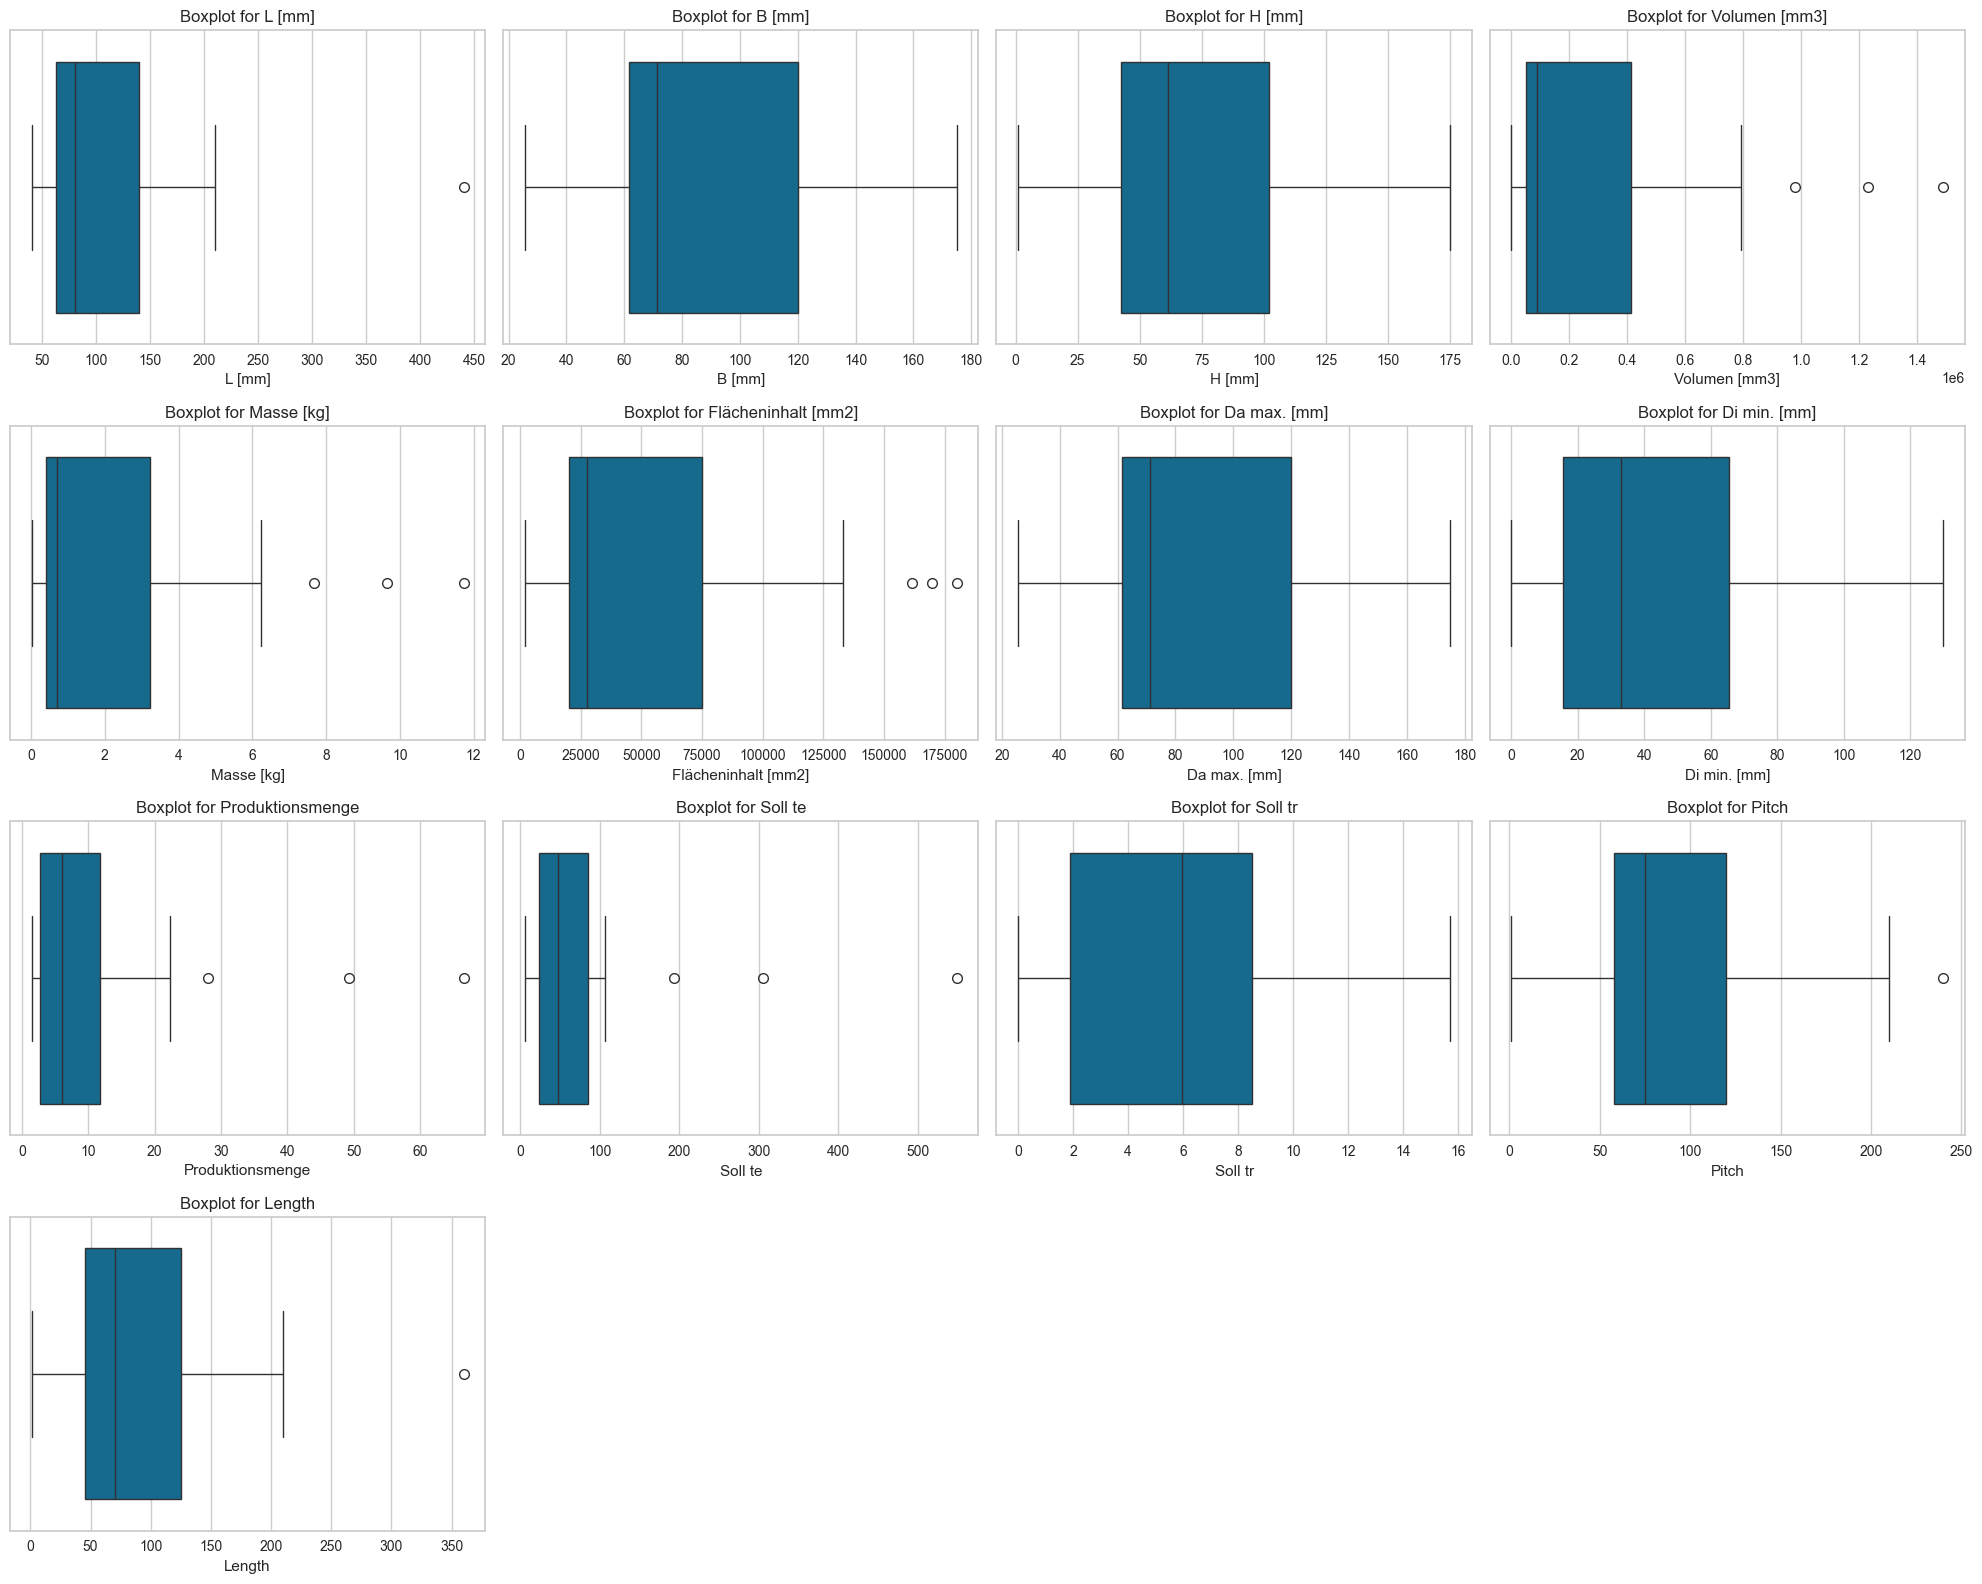

In [8]:
# show boxplots of the numerical columns
exploration.boxplots(data, num_columns)

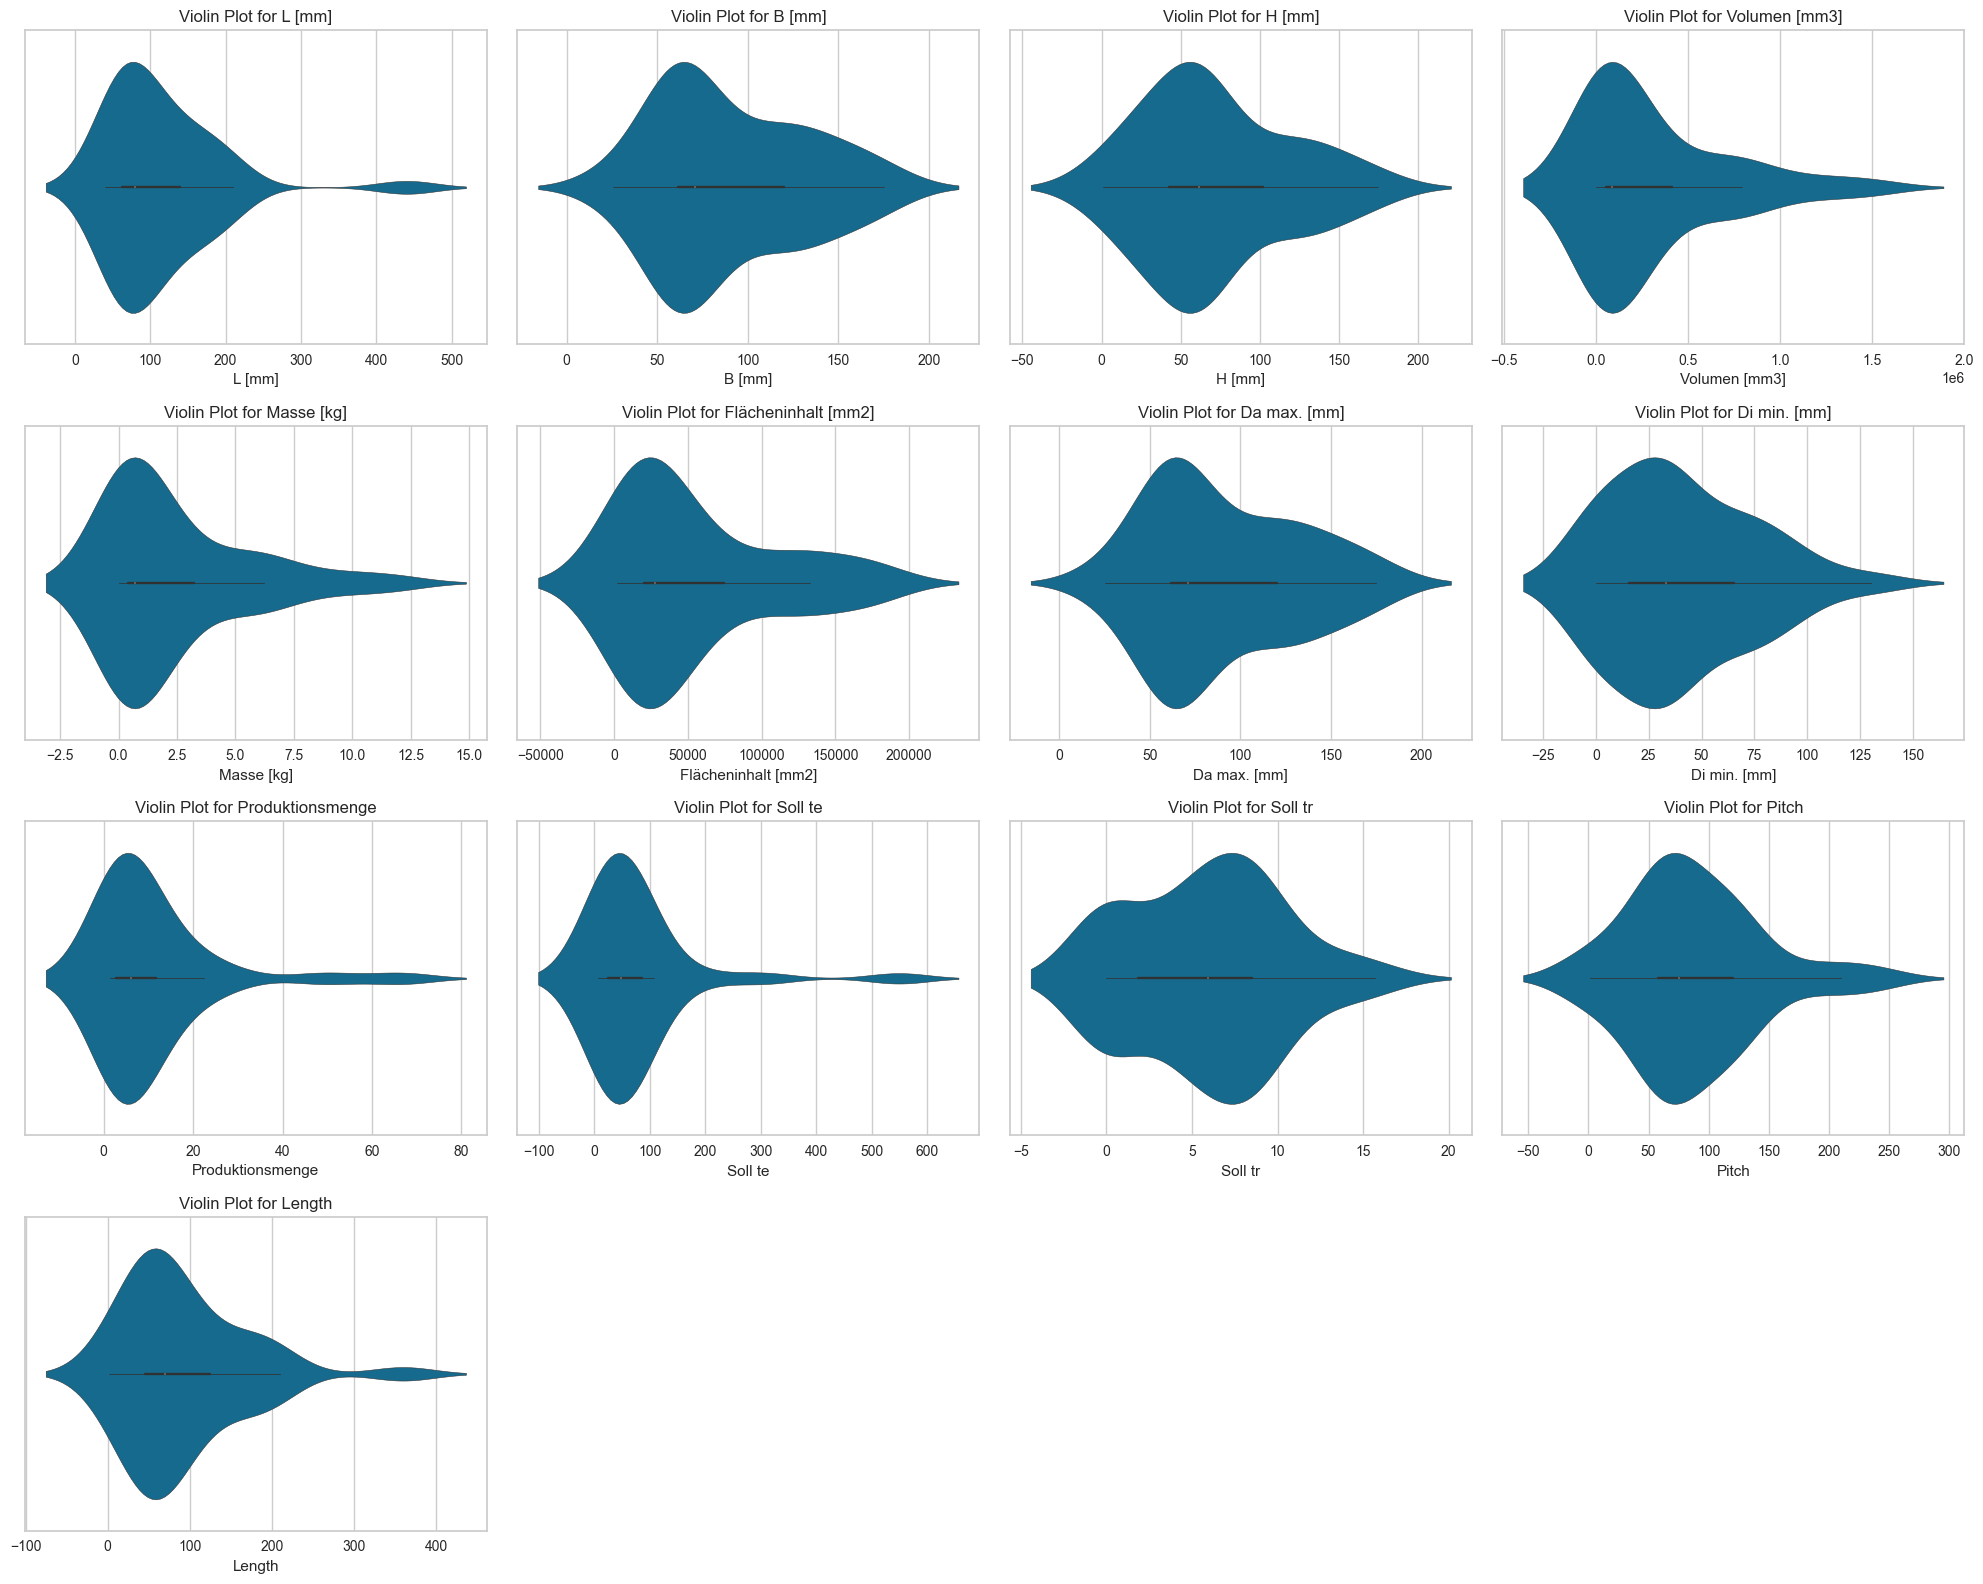

In [9]:
# show violonplot of data
exploration.violinplots(data, num_columns)

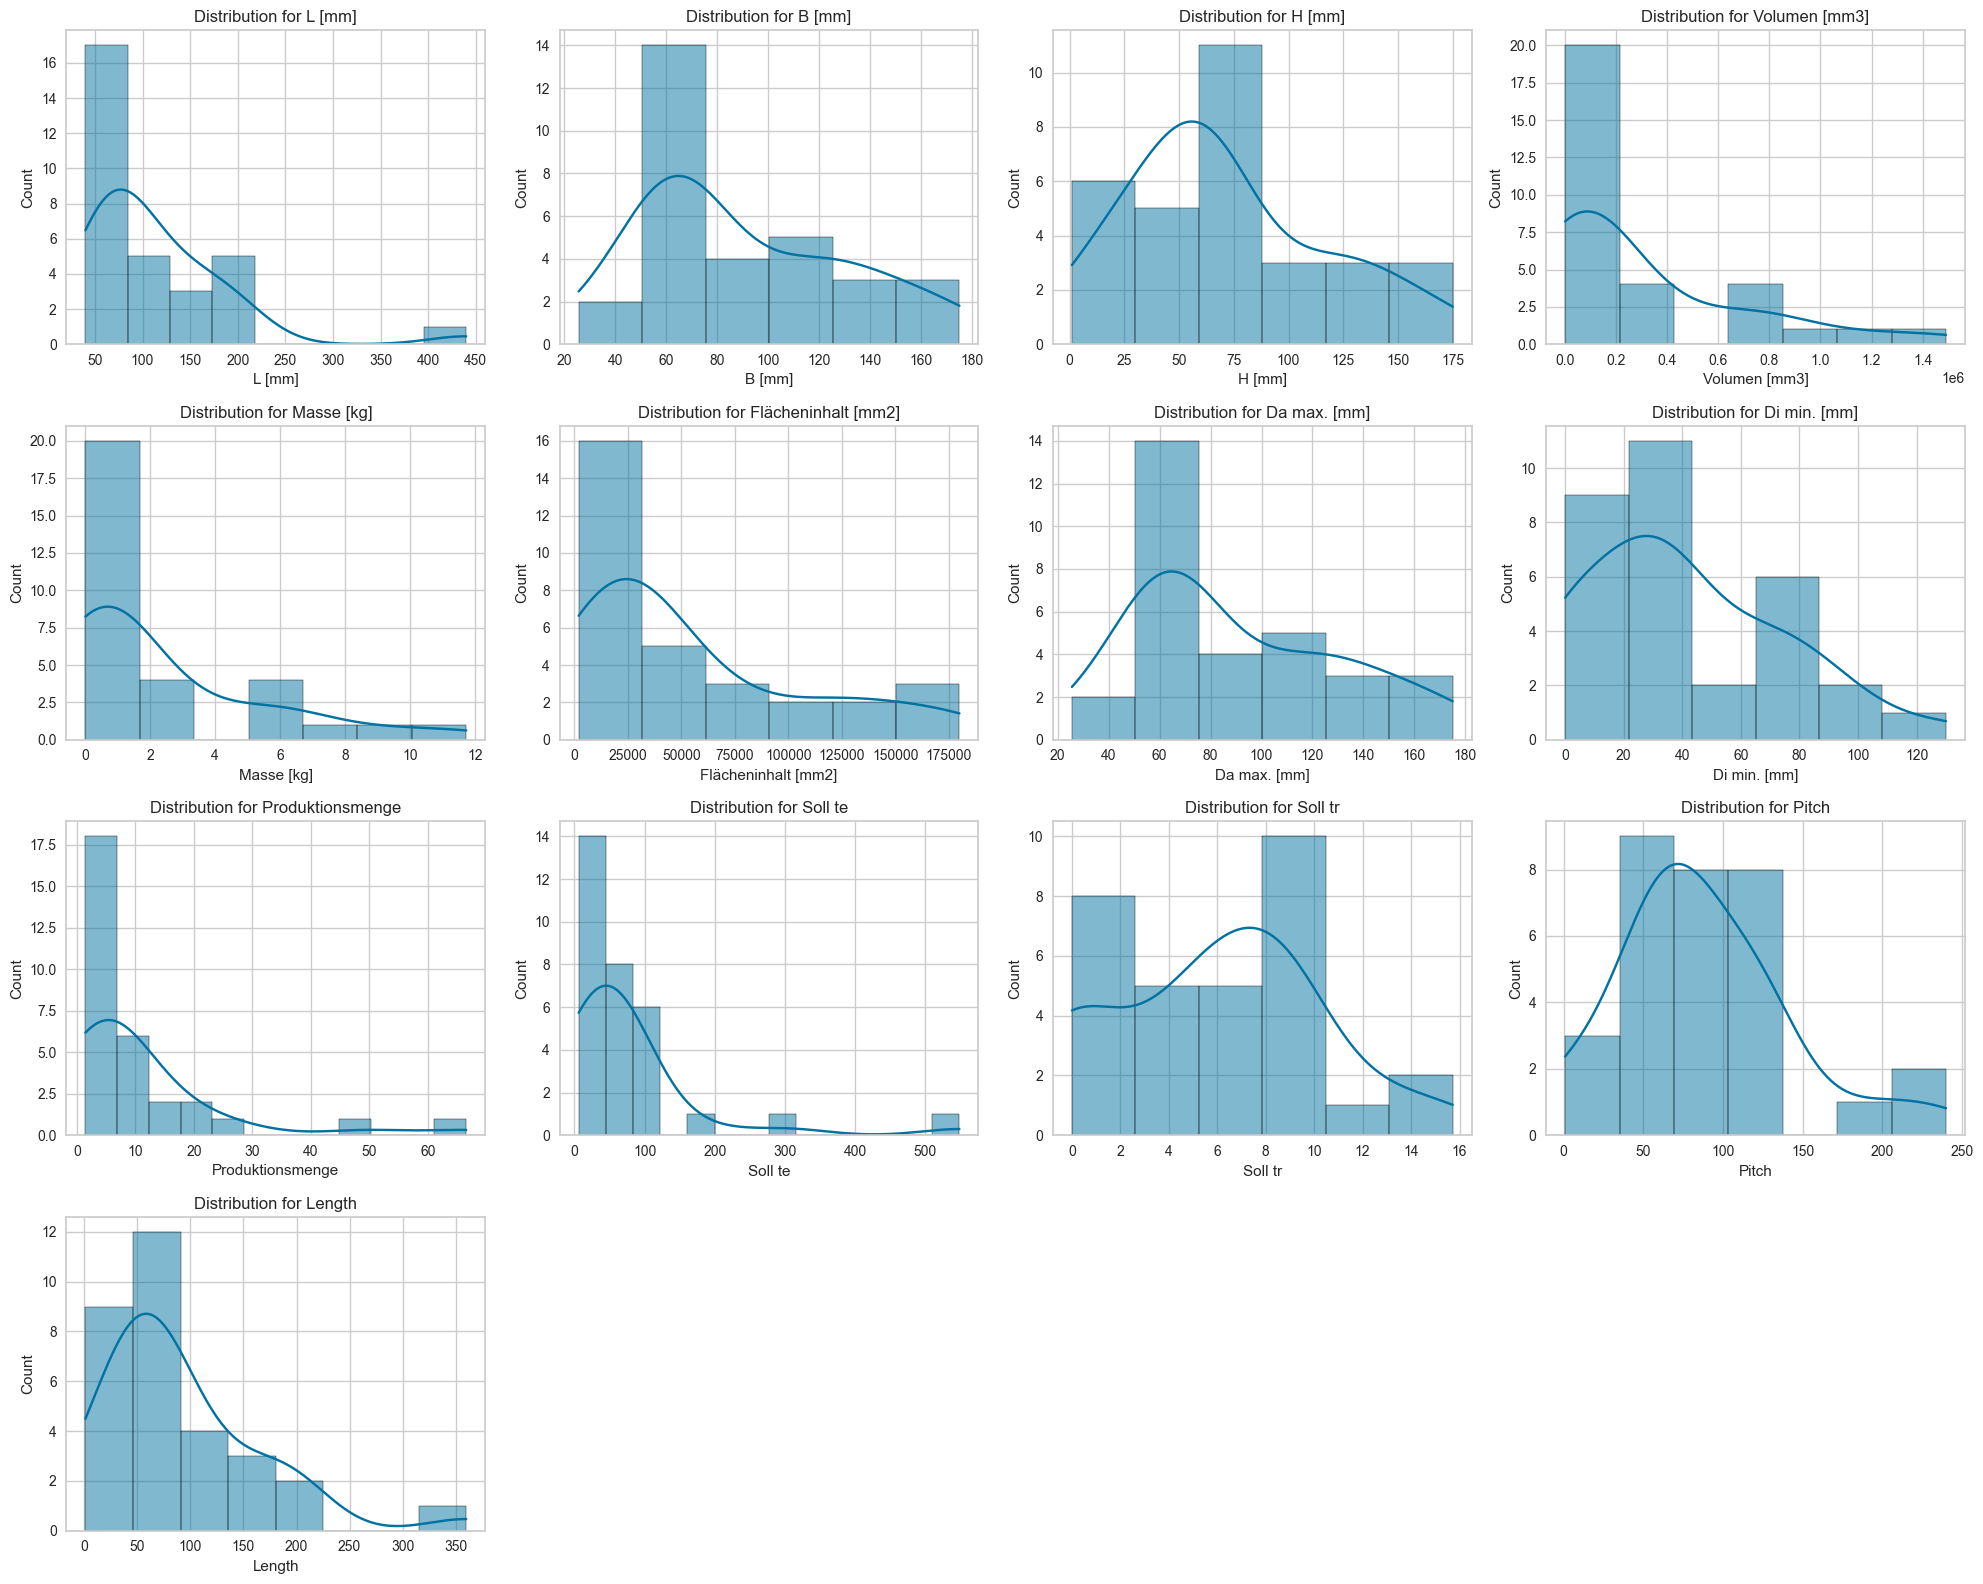

In [10]:
# show histograms of categorical columns
exploration.distributions(data, num_columns)

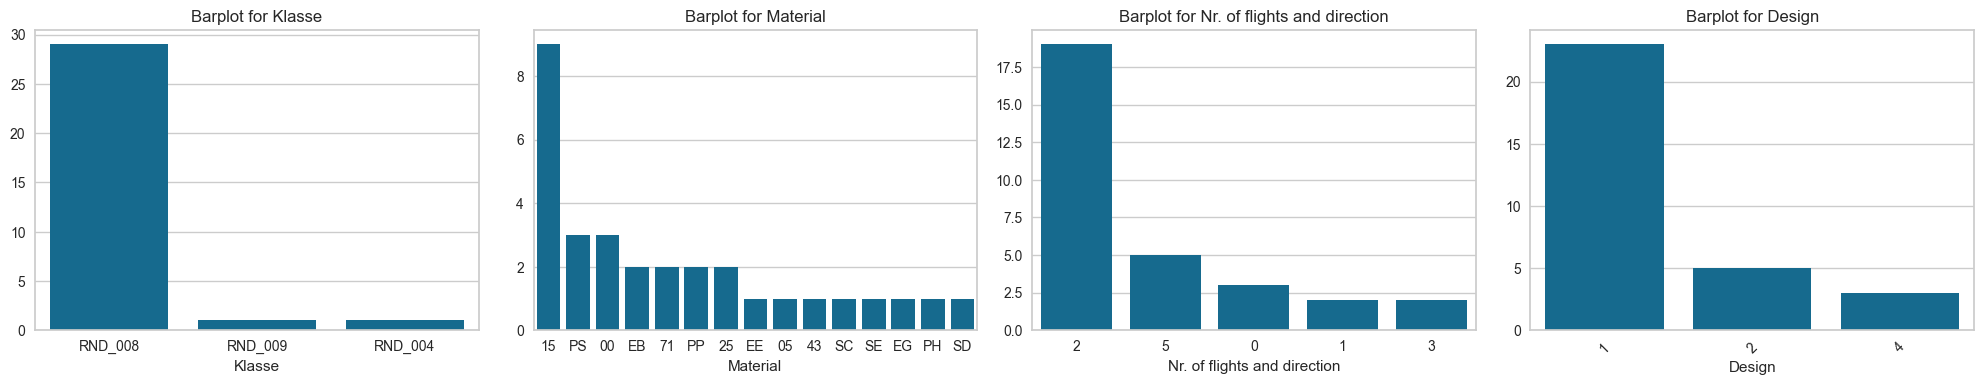

In [11]:
# show parallel_coordinates_plot of data
exploration.barplots(data, cat_columns)

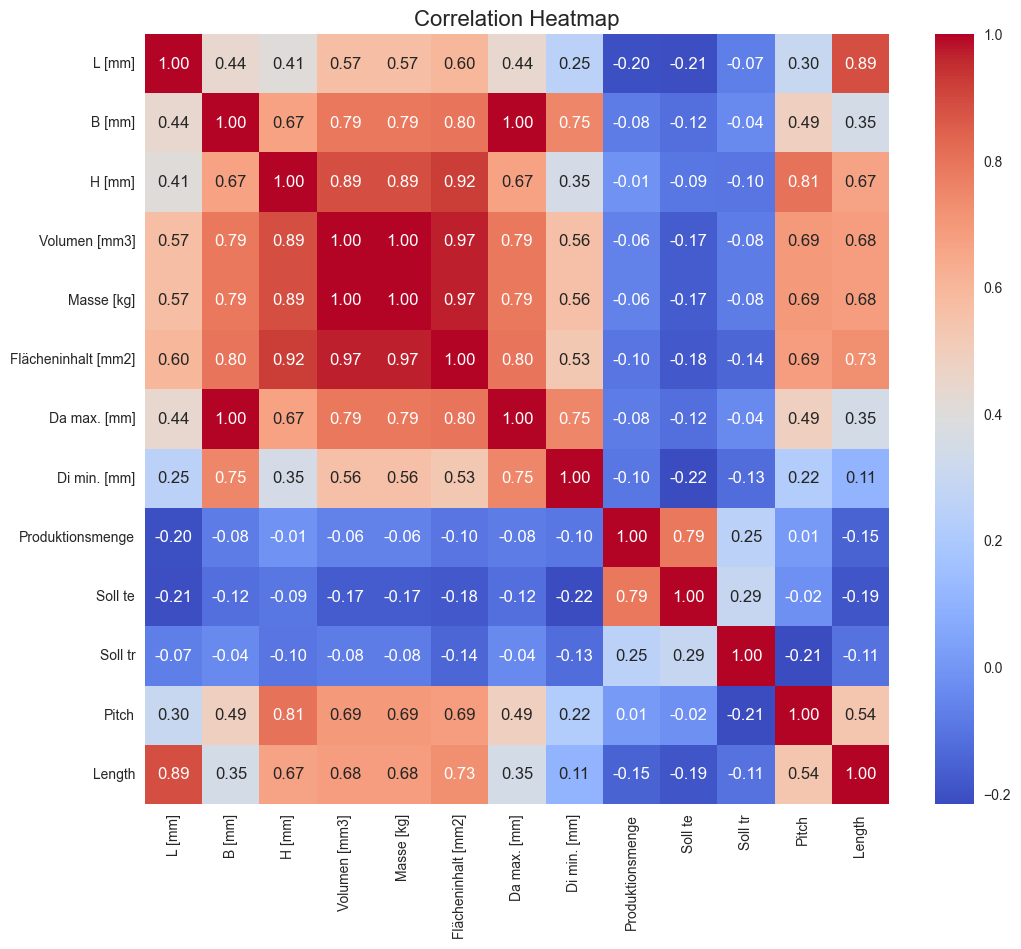

In [12]:
# show heatmap of data
exploration.heatmap(data[num_columns])

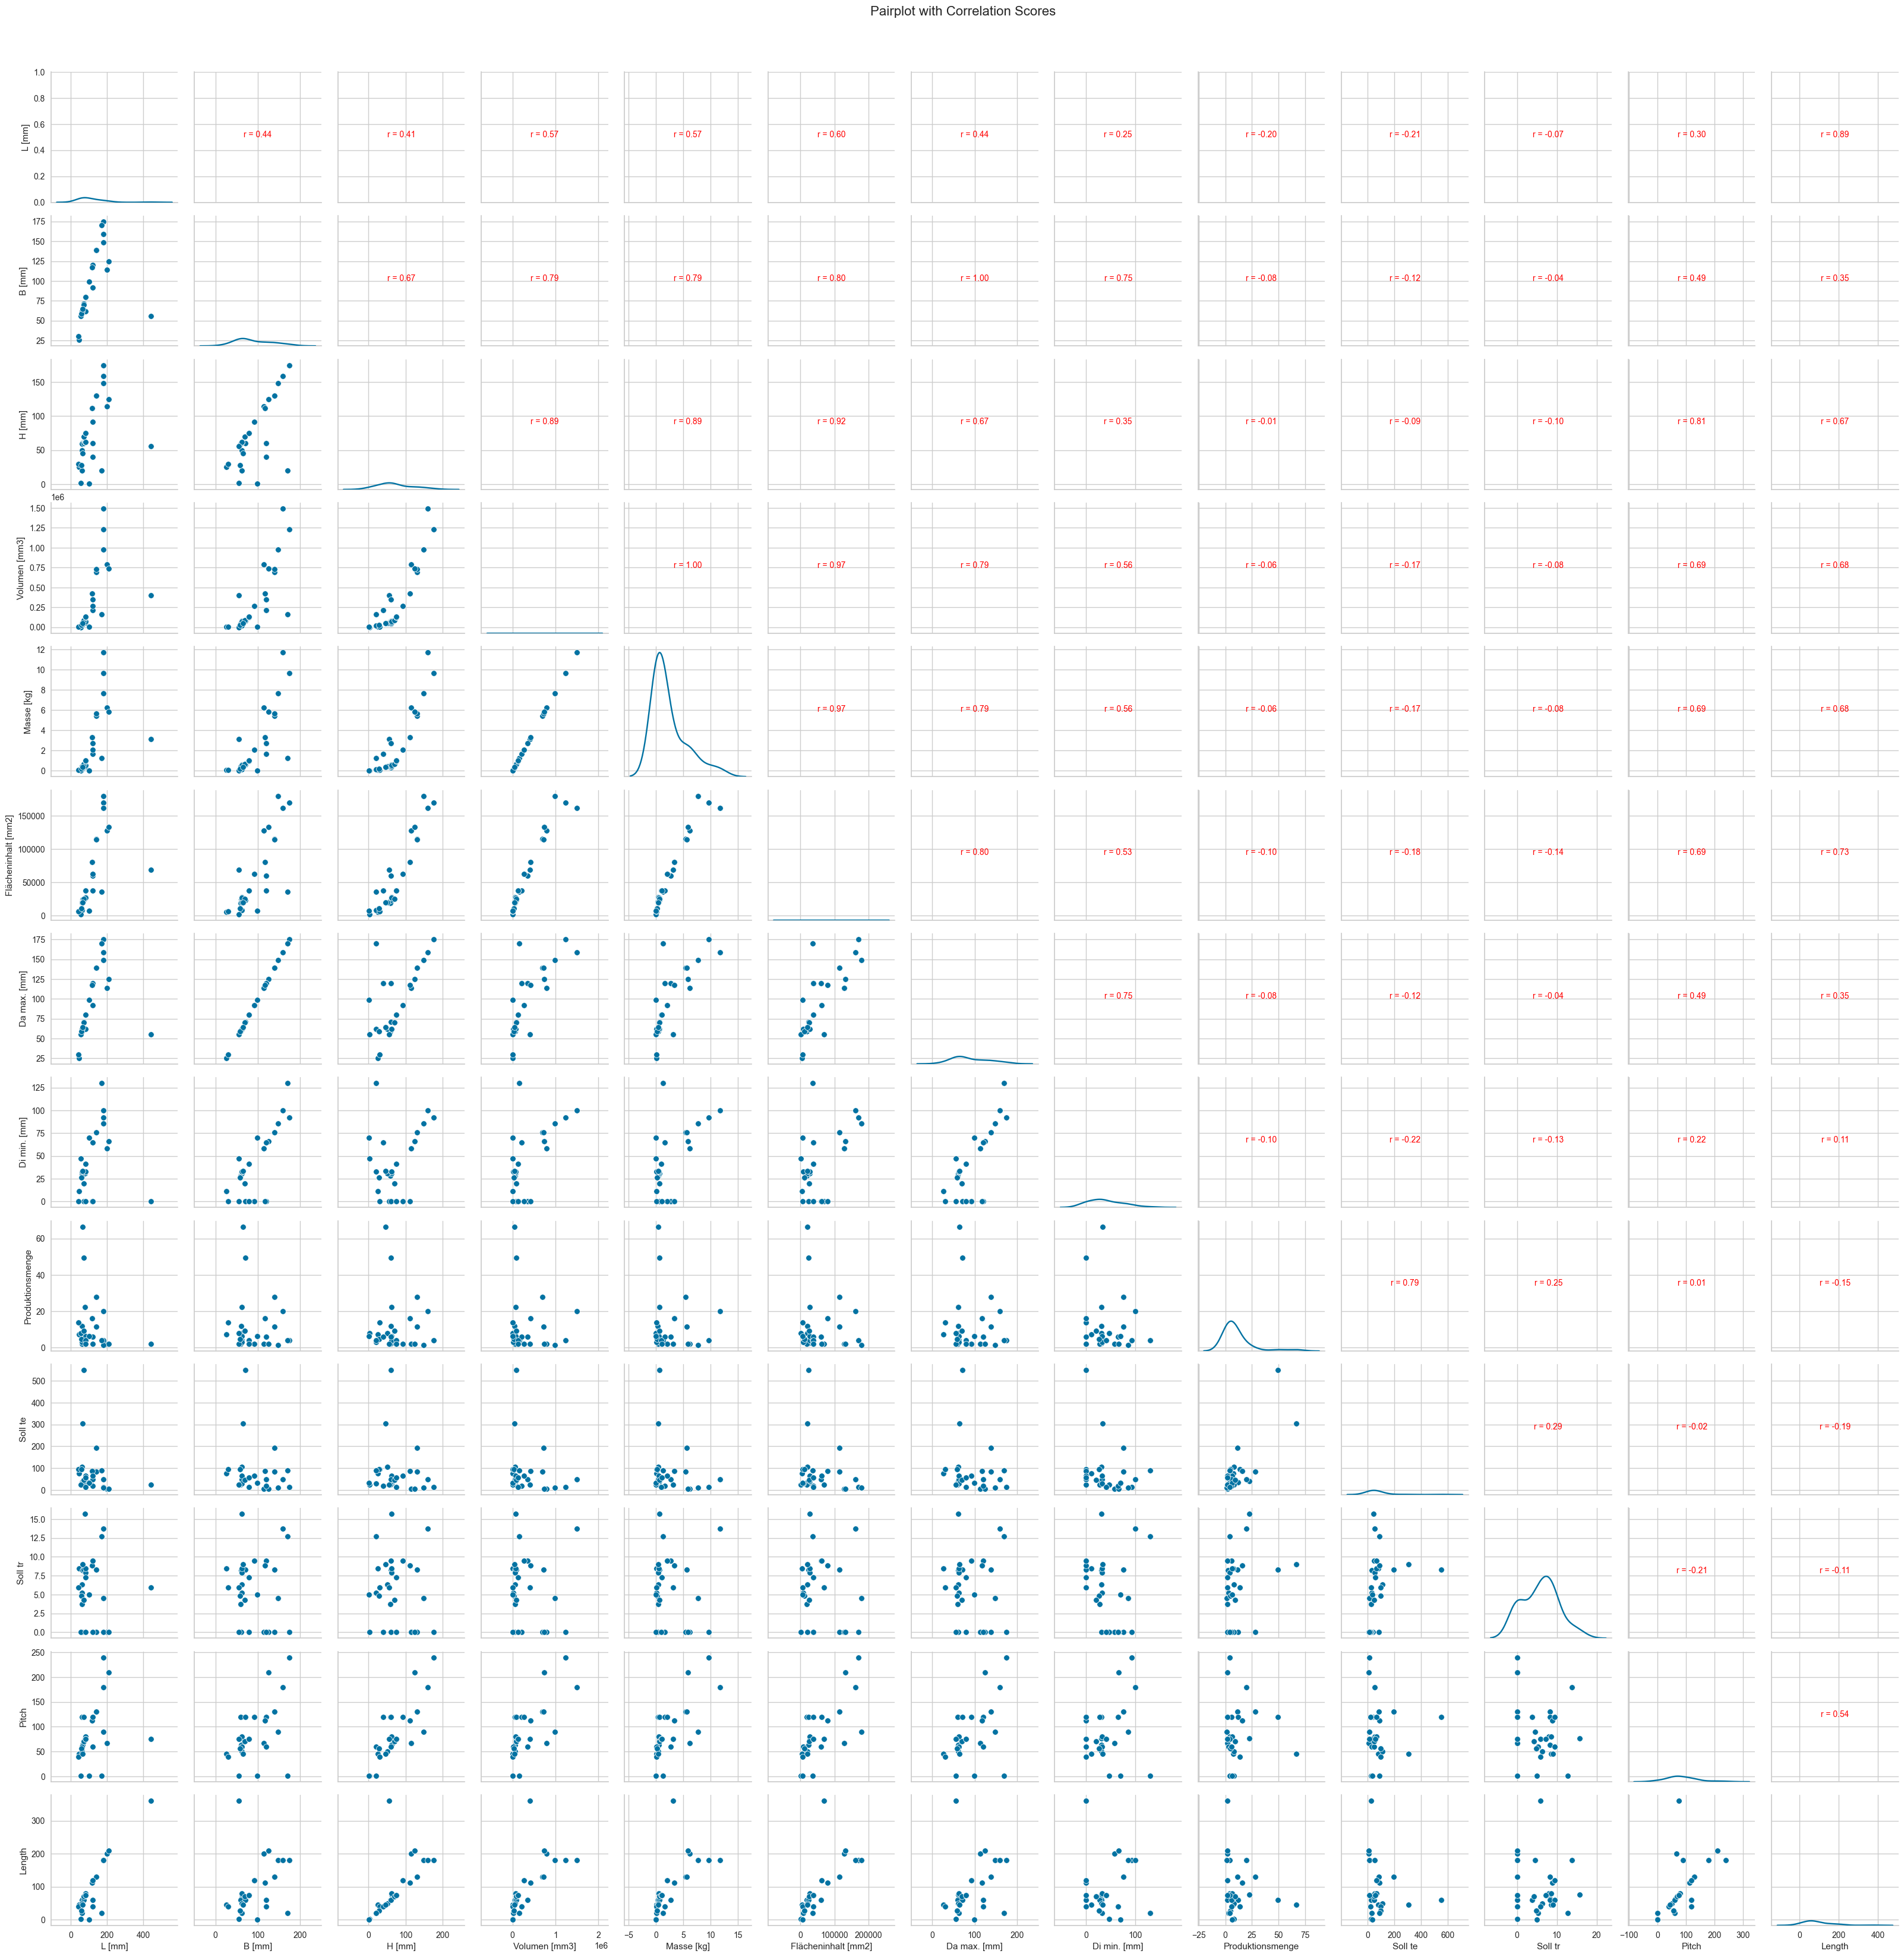

In [13]:
# show pairplot of data
exploration.pairplot(data, num_columns)

In [14]:
# z-score analysis of data
exploration.z_score_analysis(data, num_columns)

,Klasse,Volumen [mm3],Masse [kg],Flächeninhalt [mm2],L [mm],B [mm],H [mm],Lrot [mm],Da max. [mm],Di min. [mm],...,Basisressource 492000.0,Basisressource 201722.0,Produktionsmenge,Soll te,Soll tr,Material,Nr. of flights and direction,Design,Pitch,Length
Teil,,,,,,,,,,,,,,,,,,,,,
H071-1521-120-060-34,RND_008,80755.88,0.636,23783.8,71.15,71.15,60.0,60.0,71.15,0.00,...,0,0,49.333333,548.945455,8.333333,15,2,1,120.0,60.0
9070-0021-075-360-00,RND_004,402986.22,3.143,69098.8,440.00,55.50,55.5,440.0,55.50,0.00,...,0,0,2.000000,23.763636,5.909091,00,2,1,75.0,360.0
8159-1511-180-180-01,RND_008,1490660.51,11.731,161403.2,180.00,159.00,159.0,180.0,159.00,100.00,...,0,0,20.000000,50.000000,13.750000,15,1,1,180.0,180.0
7065-1551-045-045-24,RND_008,51574.56,0.406,20254.8,64.50,64.50,45.0,45.0,64.50,33.43,...,0,0,66.583658,305.674708,9.046693,15,5,1,45.0,45.0


In [15]:
exploration.isolation_forest(data, num_columns)

,Klasse,Volumen [mm3],Masse [kg],Flächeninhalt [mm2],L [mm],B [mm],H [mm],Lrot [mm],Da max. [mm],Di min. [mm],...,Basisressource 492000.0,Basisressource 201722.0,Produktionsmenge,Soll te,Soll tr,Material,Nr. of flights and direction,Design,Pitch,Length
Teil,,,,,,,,,,,,,,,,,,,,,
G175-EE21-240-180-25,RND_008,1229930.16,9.655,169652.1,180.0,175.0,175.0,180.0,175.0,92.0,...,0,0,4.0,12.0,0.00,EE,2,1,240.0,180.0
8159-1511-180-180-01,RND_008,1490660.51,11.731,161403.2,180.0,159.0,159.0,180.0,159.0,100.0,...,0,0,20.0,50.0,13.75,15,1,1,180.0,180.0


/usr/local/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


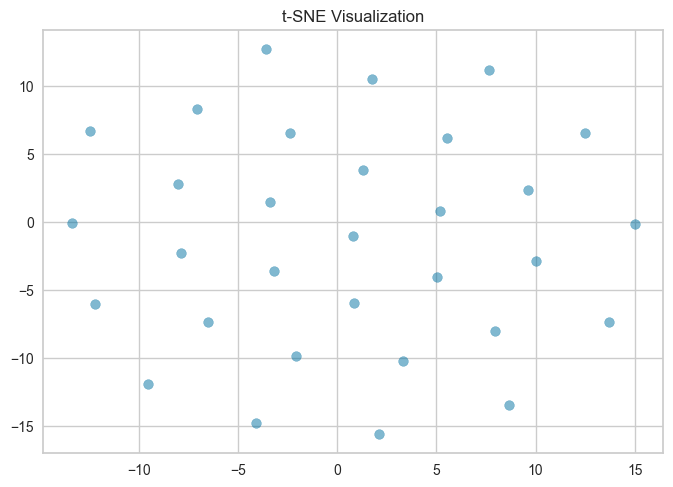

In [16]:
exploration.tsne_visualization(data, num_columns)

__Clustering__

In [17]:
distance_matrix = clustering.gower_distance(data)

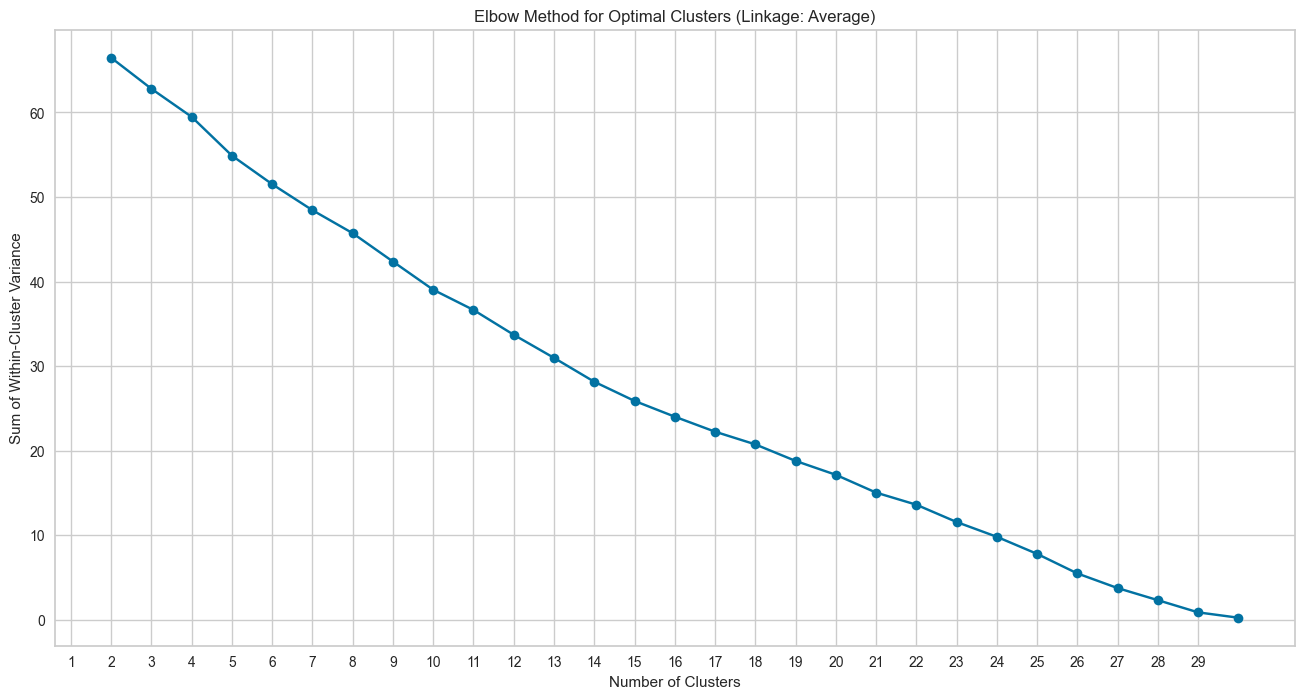

In [18]:
### plot the elbow plot for the first 20 clusters
clustering.elbow_plot_agglomerative(data_preprocessed, distance_matrix, 30)

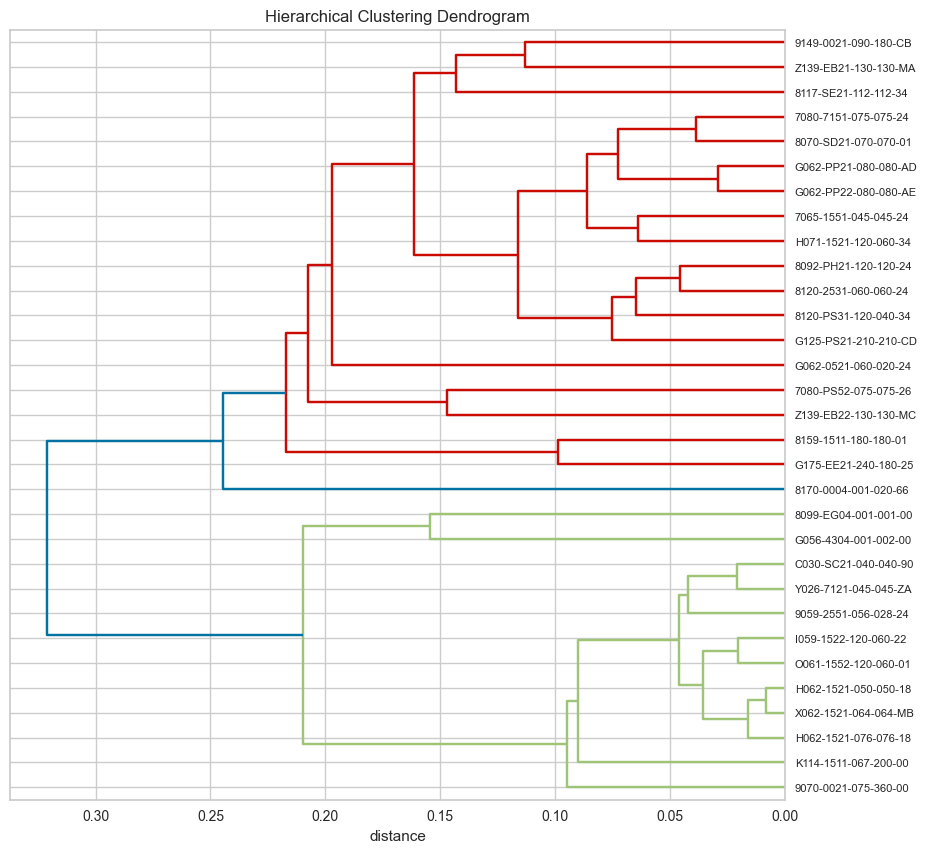

In [19]:
### plot the dendrogram
clustering.plot_dendrogram(distance_matrix, labels=data.index, orientation='left')

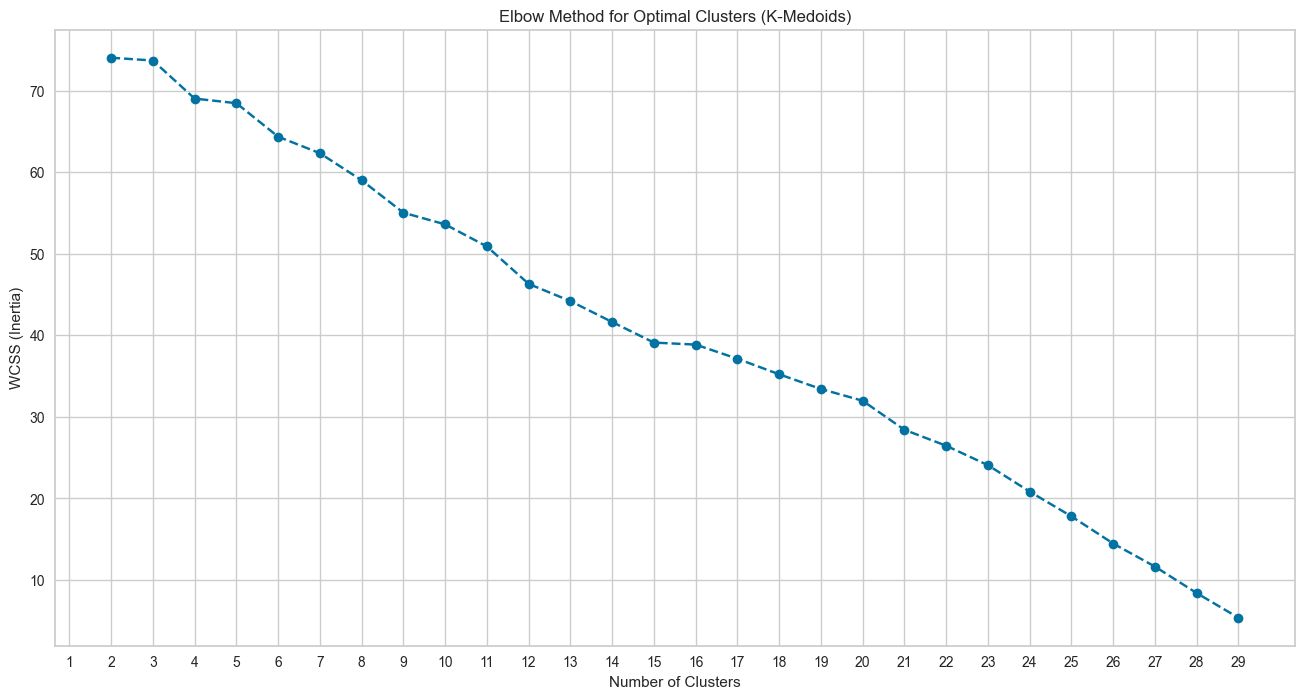

In [20]:
### find clusters with k-medoids and apply elbow and shilouette method
clustering.elbow_plot_kmedoids(data_preprocessed, 30)

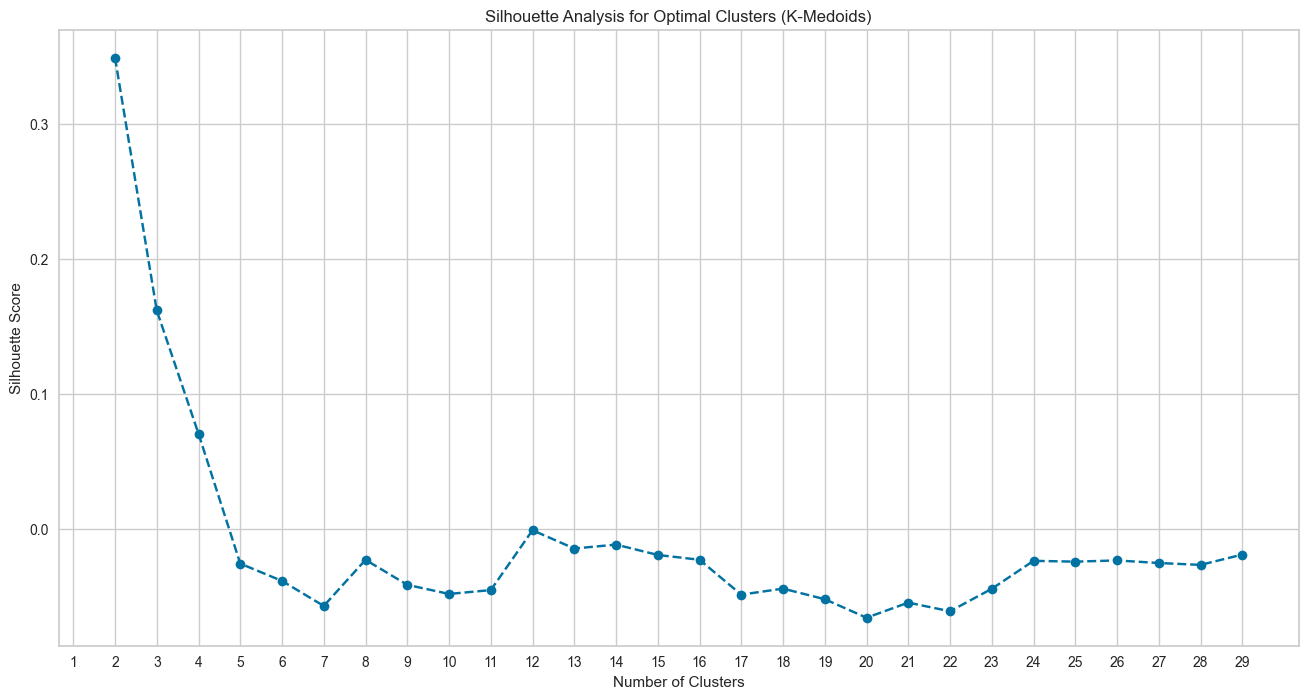

In [21]:
### find clusters with k-medoids and apply elbow and shilouette method
clustering.silhouette_score_kmedoids(data_preprocessed, 30)

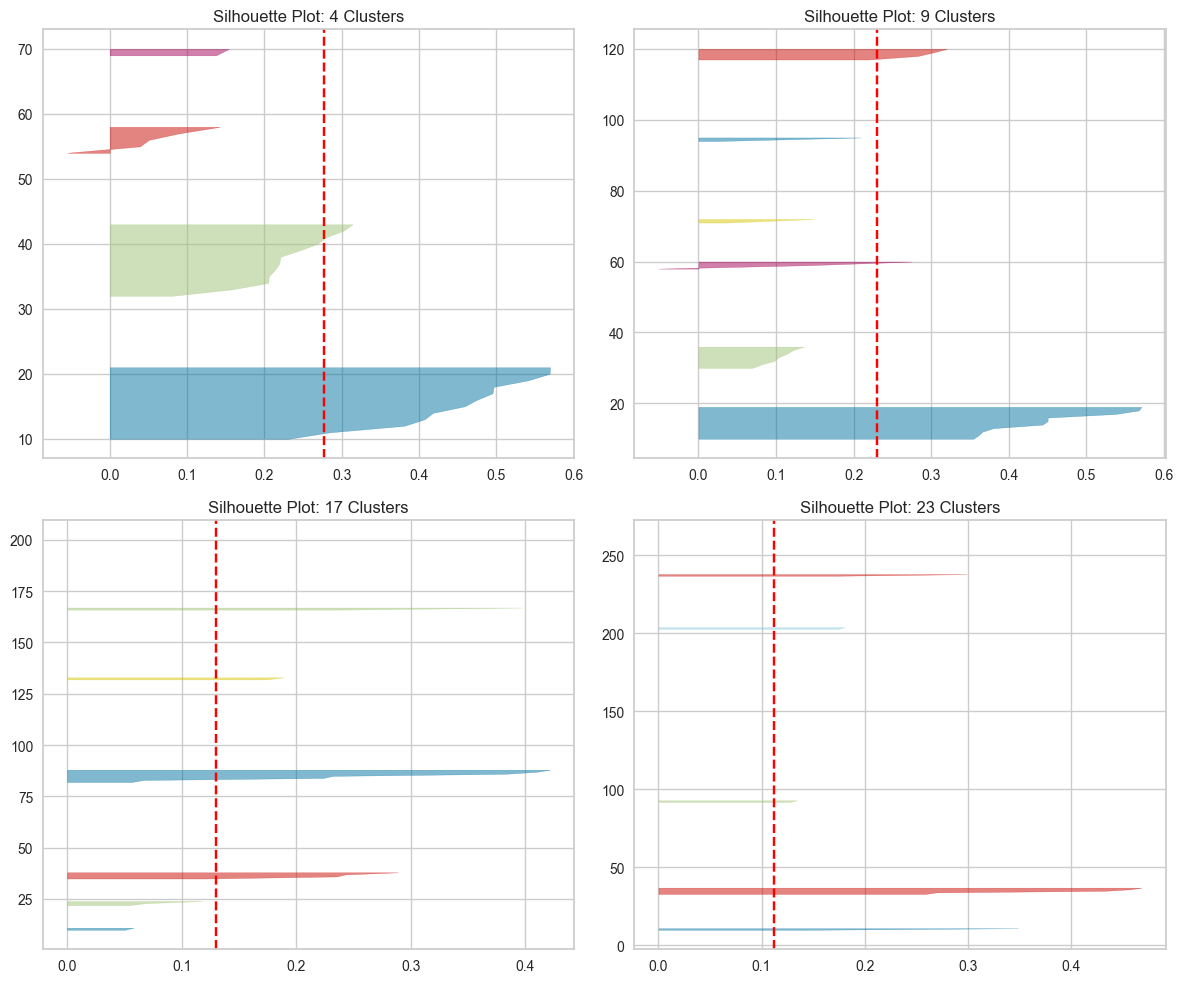

In [22]:
clustering.silhouette_plot_kmedoids(data_preprocessed, [4,9,17,23])

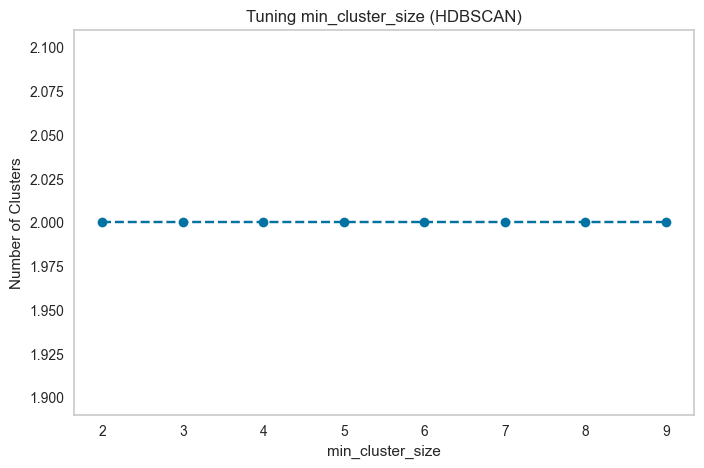

{2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2}

In [23]:
### tune min_cluster size for HDBSCAN
min_size_range = range(2, 10)
clustering.tune_min_cluster_size(distance_matrix, min_size_range)

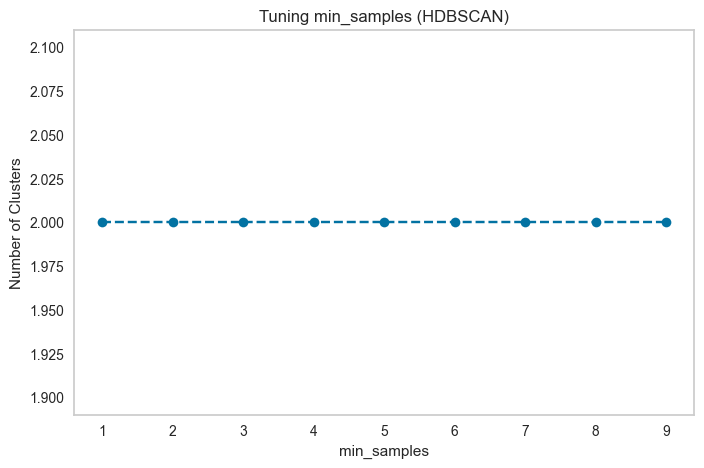

{1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2}

In [24]:
### tune min_samples for HDBSCAN
min_samples_range = range(1, 10)
clustering.tune_min_samples(distance_matrix, min_samples_range, min_cluster_size=6)

In [25]:
### Perform HDBSCAN clustering with optimal parameters
labels, clusterer = clustering.hdbscan_clustering(distance_matrix, min_cluster_size=2, min_samples=2)
### Visualize the results
clustering.plot_hdbscan_results_2d(data_preprocessed.values, labels)

AttributeError: module 'prevelop.clustering' has no attribute 'plot_hdbscan_results_2d'

__Evaluation__

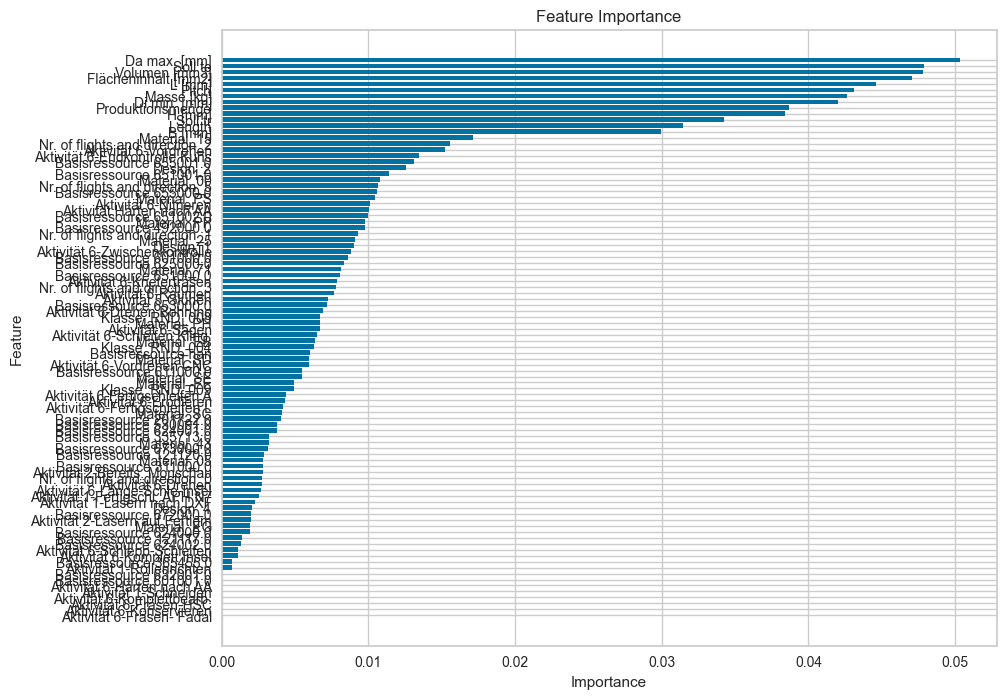

In [52]:
# feature importance
clusters = clustering.agglomerative_clustering(distance_matrix, 29)
evaluation.feature_importance(data_preprocessed, clusters)